In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import inception_v3
from scipy import linalg



# Hyperparameters



In [ ]:
manualSeed = 999
torch.manual_seed(manualSeed)

dataroot    = './data'
batch_size  = 128    
image_size  = 64    #the size of the image
nc          = 3     # number of image channels
size_latent         = 100   # size of latent vector
num_gf         = 64    # generator feature map size
num_df         = 64    # discriminator feature map size
num_epochs  = 25
lr          = 0.0002
beta1       = 0.5
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  DC-GAN Model Definitions

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(size_latent , num_gf*8, 4, 1, 0, bias=False),    # we pass the latent vector to the generator
            nn.BatchNorm2d(num_gf*8), nn.ReLU(True),
            
            nn.ConvTranspose2d(num_gf*8, num_gf*4, 4, 2, 1, bias=False),   # state size: (num_gf*8) x 4 x 4 generator_feature map size
            nn.BatchNorm2d(num_gf*4), nn.ReLU(True),
          
            nn.ConvTranspose2d(num_gf*4, num_gf*2, 4, 2, 1, bias=False),    # state size: (num_gf*4) x 8 x 8
            nn.BatchNorm2d(num_gf*2), nn.ReLU(True),
            
            nn.ConvTranspose2d(num_gf*2, num_gf, 4, 2, 1, bias=False),     # state size: (num_gf*2) x 16 x 16
            nn.BatchNorm2d(num_gf), nn.ReLU(True),
           
            nn.ConvTranspose2d(num_gf, nc, 4, 2, 1, bias=False),         # state size: (num_gf) x 32 x 32
            nn.Tanh()    #output is number of channels x 64 x 64
           
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(nc, num_df, 4, 2, 1, bias=False),     # input is (nc) x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(num_df, num_df*2, 4, 2, 1, bias=False),                 # state size: (num_df) x 32 x 32 is discriminator_feature map size
            nn.BatchNorm2d(num_df*2), nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(num_df*2, num_df*4, 4, 2, 1, bias=False),              # state size: (num_df*2) x 16 x 16 is discriminator_feature map size
            nn.BatchNorm2d(num_df*4), nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(num_df*4, num_df*8, 4, 2, 1, bias=False),                # state size: (num_df*4) x 8 x 8
            nn.BatchNorm2d(num_df*8), nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(num_df*8, 1, 4, 1, 0, bias=False),                   # state size: (num_df*8) x 4 x 4
            nn.Sigmoid()   # it is the probability of the image being real or fake
            
        )

    def forward(self, input):
        return self.main(input).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Instantiate models
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

# Loss & Optimizers

In [ ]:

criterion    = nn.BCELoss()
fixed_noise  = torch.randn(100, size_latent , 1, 1, device=device)
real_label   = 1.0
fake_label   = 0.0
optimizerD   = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG   = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Data Loader (CIFAR-10)

In [6]:
dataset = torchvision.datasets.CIFAR10(root=dataroot, download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


#  Experiment 1: Train DC-GAN and plot loss curves

Starting Training Loop...
Epoch [1/25]  Loss_D: 0.4891  Loss_G: 1.6359
Epoch [2/25]  Loss_D: 0.1112  Loss_G: 4.4027
Epoch [3/25]  Loss_D: 0.5781  Loss_G: 2.5958
Epoch [4/25]  Loss_D: 0.6018  Loss_G: 2.0009
Epoch [5/25]  Loss_D: 0.9837  Loss_G: 3.7189
Epoch [6/25]  Loss_D: 0.6141  Loss_G: 3.4685
Epoch [7/25]  Loss_D: 0.8633  Loss_G: 5.6947
Epoch [8/25]  Loss_D: 0.2517  Loss_G: 3.0193
Epoch [9/25]  Loss_D: 0.8743  Loss_G: 3.4585
Epoch [10/25]  Loss_D: 0.2771  Loss_G: 7.9907
Epoch [11/25]  Loss_D: 1.0628  Loss_G: 0.9108
Epoch [12/25]  Loss_D: 0.2002  Loss_G: 5.4967
Epoch [13/25]  Loss_D: 1.1889  Loss_G: 1.3058
Epoch [14/25]  Loss_D: 0.4508  Loss_G: 2.8252
Epoch [15/25]  Loss_D: 0.4541  Loss_G: 3.1116
Epoch [16/25]  Loss_D: 1.1818  Loss_G: 0.9830
Epoch [17/25]  Loss_D: 0.0783  Loss_G: 3.8875
Epoch [18/25]  Loss_D: 0.2272  Loss_G: 4.8824
Epoch [19/25]  Loss_D: 0.9133  Loss_G: 1.2433
Epoch [20/25]  Loss_D: 0.1217  Loss_G: 3.6172
Epoch [21/25]  Loss_D: 0.0476  Loss_G: 4.6633
Epoch [22/25]  Lo

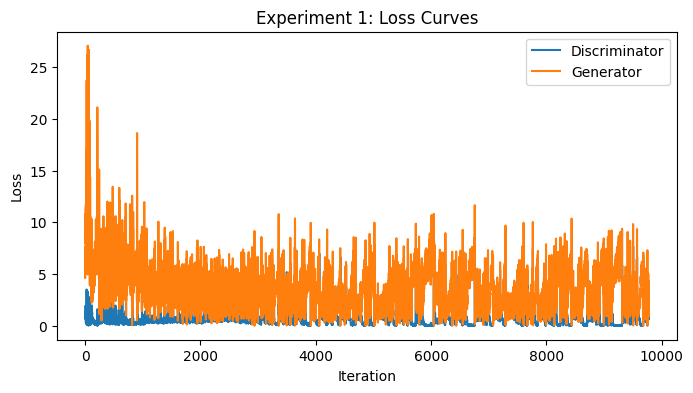

In [ ]:
Generator_losses = []
Discr_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        #  Discriminator code
        netD.zero_grad()          # we pass the image to the discriminator
        real = data[0].to(device)  # real image
        b_size = real.size(0)     
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, size_latent , 1, 1, device=device)
        fake  = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        #  Generator code
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Record losses
        Generator_losses.append(errG.item())
        Discr_losses.append(errD.item())

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {errD.item():.4f}  Loss_G: {errG.item():.4f}")

# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(Discr_losses, label="Discriminator")
plt.plot(Generator_losses, label="Generator")
plt.title("Experiment 1: Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


#  Experiment 2: 10x10 Grid of Generated Images

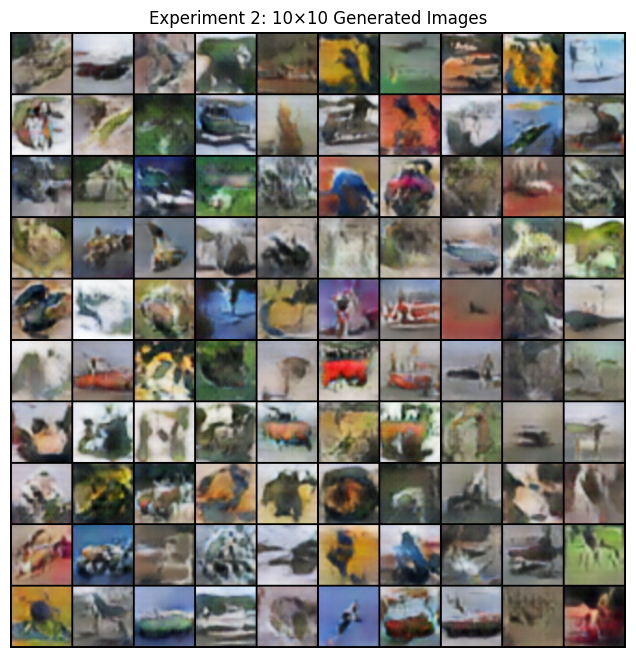

In [ ]:



with torch.no_grad():
    fake_images = netG(fixed_noise).cpu()                # we are passing the noise thhrough the generator
grid = vutils.make_grid(fake_images, nrow=10, normalize=True)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Experiment 2: 10×10 Generated Images")
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()


#  Experiment 3: Vary G/D training ratio (fixed)

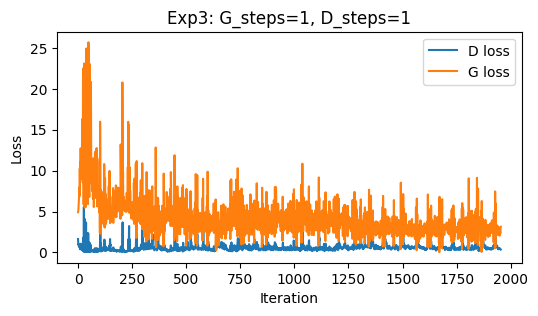

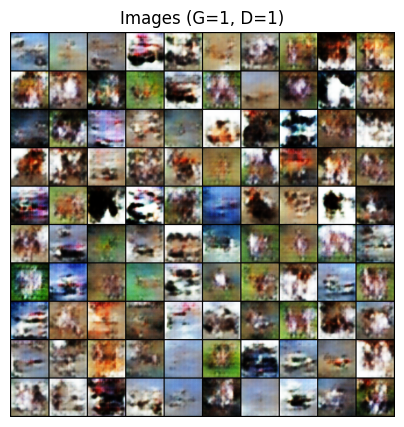

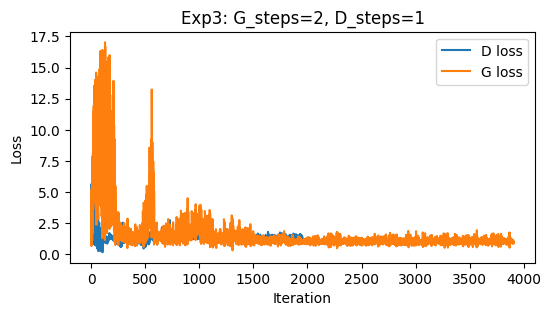

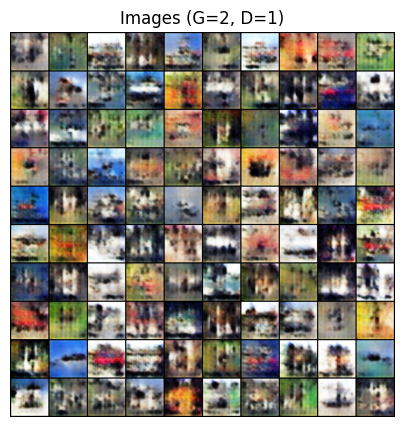

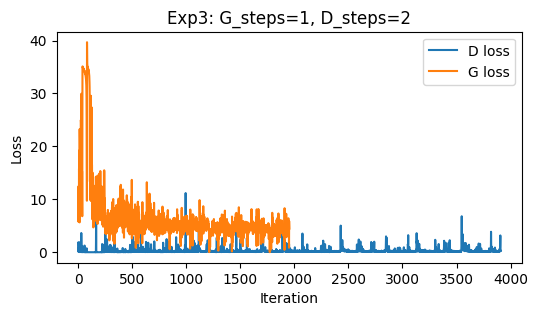

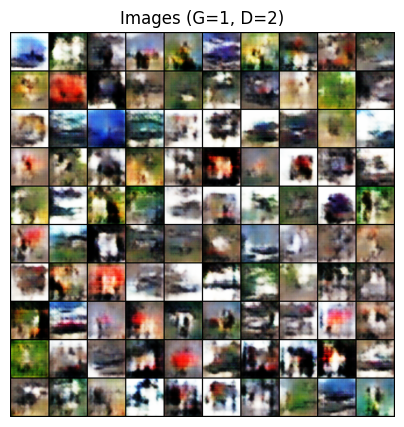

In [ ]:
def train_with_ratio(gen_steps=1, disc_steps=1, epochs=5):
    G = Generator().to(device); G.apply(weights_init)
    D = Discriminator().to(device); D.apply(weights_init)
    optG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
    optD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
    G_losses_r, D_losses_r = [], []

    for _ in range(epochs):
        for real_batch in dataloader:
            real = real_batch[0].to(device)
            b_size = real.size(0)

            # --- Discriminator updates ---
            for _ in range(disc_steps):
                D.zero_grad()
                # real loss
                labels_real = torch.full((b_size,), real_label, device=device)
                out_real = D(real)
                lossD_real = criterion(out_real, labels_real)
                # fake loss
                noise = torch.randn(b_size, size_latent , 1, 1, device=device)
                fake_imgs = G(noise)
                labels_fake = torch.full((b_size,), fake_label, device=device)
                out_fake = D(fake_imgs.detach())
                lossD_fake = criterion(out_fake, labels_fake)
                # combined and step
                lossD = lossD_real + lossD_fake
                lossD.backward()
                optD.step()
                D_losses_r.append(lossD.item())

            # --- Generator updates ---
            for _ in range(gen_steps):
                G.zero_grad()
                noise = torch.randn(b_size, size_latent , 1, 1, device=device)
                gen_imgs = G(noise)
                labels_gen = torch.full((b_size,), real_label, device=device)
                out_gen = D(gen_imgs)
                lossG = criterion(out_gen, labels_gen)
                lossG.backward()
                optG.step()
                G_losses_r.append(lossG.item())

    return G, G_losses_r, D_losses_r

# run for different ratios
for (g_s, d_s) in [(1,1), (2,1), (1,2)]:
    Gm, G_losses_ratio, D_losses_ratio = train_with_ratio(gen_steps=g_s, disc_steps=d_s)
    plt.figure(figsize=(6,3))
    plt.plot(D_losses_ratio, label="D loss")
    plt.plot(G_losses_ratio, label="G loss")
    plt.title(f"Exp3: G_steps={g_s}, D_steps={d_s}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    with torch.no_grad():
        sample = Gm(fixed_noise).cpu()
    grid = vutils.make_grid(sample, nrow=10, normalize=True)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title(f"Images (G={g_s}, D={d_s})")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()


#  Experiment 4: Compute FID between 1000 real & generated images (with resizing)

In [ ]:
import torch.nn.functional as F

# Adapted get_activations that upsamples to 299×299 and handles batched inference
def get_activations(x, model, batch_size=50):
    """
    x: torch.Tensor of shape (N, 3, 64, 64), values in [-1, 1]
    model: inception_v3 with fc replaced by Identity
    """
    model.eval()
    activations = []
    with torch.no_grad():
        for i in range(0, x.size(0), batch_size):
            batch = x[i:i+batch_size]
            # scale from [-1,1] to [0,1]
            batch = (batch + 1) / 2
            # upsample to inception input size (299×299)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            preds = model(batch)
            # inception_v3 returns (logits, aux_logits) if aux_logits=True
            if isinstance(preds, tuple):
                preds = preds[0]
            activations.append(preds.cpu().numpy())
    return np.concatenate(activations, axis=0)

# FID computation function
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ((mu1 - mu2)**2).sum() + np.trace(sigma1 + sigma2 - 2*covmean)

# 1) Prepare inception model
inc = inception_v3(pretrained=True, transform_input=False, aux_logits=True).to(device)
inc.fc = nn.Identity()

# 2) Collect 1000 real CIFAR-10 images
real_imgs = []
for xb, _ in dataloader:
    real_imgs.append(xb)
    if len(real_imgs) * batch_size >= 1000:
        break
real_imgs = torch.cat(real_imgs, 0)[:1000].to(device)

# 3) Generate 1000 fake images
gen_imgs = []
with torch.no_grad():
    while len(gen_imgs) * batch_size < 1000:
        noise = torch.randn(batch_size, size_latent , 1, 1, device=device)
        gen_imgs.append(netG(noise))
gen_imgs = torch.cat(gen_imgs, 0)[:1000].to(device)

# 4) Get activations
act_real = get_activations(real_imgs, inc)
act_fake = get_activations(gen_imgs, inc)

# 5) Compute statistics
mu_r, sigma_r = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
mu_f, sigma_f = act_fake.mean(axis=0), np.cov(act_fake, rowvar=False)

# 6) Compute FID
fid_score = calculate_fid(mu_r, sigma_r, mu_f, sigma_f)
print("Experiment 4: FID =", fid_score)


Experiment 4: FID = 80.75927574312107


In [ ]:
import torch.nn.functional as F
import numpy as np
from torchvision.models import inception_v3
from scipy import linalg

# Function to get activations from the inception model
def get_activations(x, model, batch_size=50):
    """
    x: torch.Tensor of shape (N, 3, 64, 64), values in [-1, 1]
    model: inception_v3 with fc replaced by Identity
    """
    model.eval()
    activations = []
    with torch.no_grad():
        for i in range(0, x.size(0), batch_size):
            batch = x[i:i+batch_size]
            # scale from [-1,1] to [0,1]
            batch = (batch + 1) / 2
            # upsample to inception input size (299×299)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            preds = model(batch)
            # inception_v3 returns (logits, aux_logits) if aux_logits=True
            if isinstance(preds, tuple):
                preds = preds[0]
            activations.append(preds.cpu().numpy())
    return np.concatenate(activations, axis=0)

# FID computation function
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return ((mu1 - mu2)**2).sum() + np.trace(sigma1 + sigma2 - 2*covmean)

# Function to run experiment and compute FID
def run_experiment_and_compute_fid(G_steps, D_steps, dataloader, netG, device, batch_size, size_latent , inc, criterion, fixed_noise):
    # Run the experiment with specified G_steps and D_steps
    Gm, G_losses_ratio, D_losses_ratio = train_with_ratio(gen_steps=G_steps, disc_steps=D_steps)

    # Collect 1000 real CIFAR-10 images
    real_imgs = []
    for xb, _ in dataloader:
        real_imgs.append(xb)
        if len(real_imgs) * batch_size >= 1000:
            break
    real_imgs = torch.cat(real_imgs, 0)[:1000].to(device)

    # Generate 1000 fake images
    gen_imgs = []
    with torch.no_grad():
        while len(gen_imgs) * batch_size < 1000:
            noise = torch.randn(batch_size, size_latent , 1, 1, device=device)
            gen_imgs.append(Gm(noise))
    gen_imgs = torch.cat(gen_imgs, 0)[:1000].to(device)

    # Get activations for real and generated images
    act_real = get_activations(real_imgs, inc)
    act_fake = get_activations(gen_imgs, inc)

    # Compute statistics
    mu_r, sigma_r = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_f, sigma_f = act_fake.mean(axis=0), np.cov(act_fake, rowvar=False)

    # Compute FID score
    fid_score = calculate_fid(mu_r, sigma_r, mu_f, sigma_f)
    print(f"FID for G_steps={G_steps}, D_steps={D_steps}: {fid_score}")
    return fid_score

# 1) Prepare inception model
inc = inception_v3(pretrained=True, transform_input=False, aux_logits=True).to(device)
inc.fc = nn.Identity()

# 2) Experiment with different G_steps and D_steps
fid_scores = {}
for (g_s, d_s) in [(1, 1), (2, 1), (1, 2)]:
    fid_scores[(g_s, d_s)] = run_experiment_and_compute_fid(
        G_steps=g_s, D_steps=d_s, dataloader=dataloader, netG=netG, device=device, 
        batch_size=batch_size, size_latent =size_latent , inc=inc, criterion=criterion, fixed_noise=fixed_noise)

# FID scores for each configuration
for config, score in fid_scores.items():
    print(f"FID for G_steps={config[0]}, D_steps={config[1]}: {score}")


FID for G_steps=1, D_steps=1: 139.09769253395447
FID for G_steps=2, D_steps=1: 196.88449980398073
FID for G_steps=1, D_steps=2: 122.03967895391722
FID for G_steps=1, D_steps=1: 139.09769253395447
FID for G_steps=2, D_steps=1: 196.88449980398073
FID for G_steps=1, D_steps=2: 122.03967895391722


# Experiment 5: Latent-space interpolation

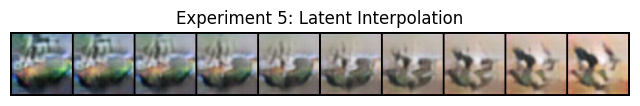

In [ ]:

def interpolate(z1, z2, steps=10):
    ratios = np.linspace(0,1,steps)
    return torch.stack([(1-r)*z1 + r*z2 for r in ratios])

z1 = torch.randn(1,size_latent ,1,1, device=device)
z2 = torch.randn(1,size_latent ,1,1, device=device)
interp = interpolate(z1.view(-1), z2.view(-1), 10).view(10,size_latent ,1,1)
with torch.no_grad():
    imgs = netG(interp).cpu()            # we are passing the noise through the generator
grid_i = vutils.make_grid(imgs, nrow=10, normalize=True)
plt.figure(figsize=(8,2))
plt.axis('off')
plt.title("Experiment 5: Latent Interpolation")
plt.imshow(np.transpose(grid_i, (1,2,0)))
plt.show()


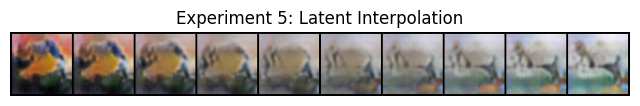